In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from spglm.iwls import _compute_betas_gwr, iwls  
from spglm.family import Gaussian
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from statsmodels.api import OLS
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.diagnostics import get_AICc
import geopandas as gpd
from shapely.geometry import Point, Polygon

import warnings
warnings.filterwarnings('ignore')
# Gaussian family initialization
family = Gaussian()
np.set_printoptions(precision=3, suppress=True)

In [2]:
# Function to create tract polygons over the area
def create_tracts(xmin, xmax, ymin, ymax, x_step, y_step):
    polys = []
    ids = []
    id_counter = 0
    for x0 in np.arange(xmin, xmax, x_step):
        for y0 in np.arange(ymin, ymax, y_step):
            x1 = x0 + x_step
            y1 = y0 + y_step
            poly = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
            polys.append(poly)
            ids.append(id_counter)
            id_counter += 1
    gdf = gpd.GeoDataFrame({'tract_id': ids, 'geometry': polys})
    return gdf

# Define grid parameters and create tracts
xmin, xmax = 0, 100
ymin, ymax = 0, 100

# This is the step where I choose the size of the tracts 
x_step, y_step = 10, 5  # Creates a 10x5 grid, resulting in 200 tracts
tracts_gdf = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2
def simulate_S2(num_points):
    np.random.seed(26)
    locations = np.random.rand(num_points, 2) * 100
    s2 = np.random.normal(50, 30, num_points)
    return s2, locations

S2, loc2 = simulate_S2(350)

#### Plot tracts and points

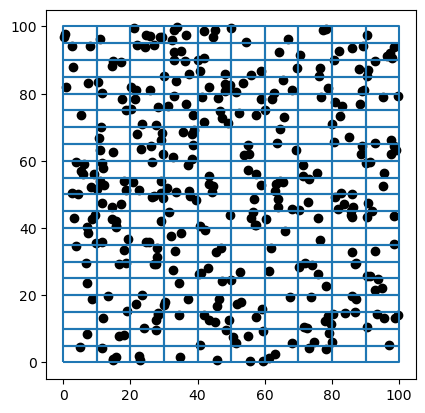

In [3]:
tracts_gdf.boundary.plot()
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

In [4]:
len(tracts_gdf)

200

#### Create beta surfaces and base DGP

In [5]:
S1 = tracts_gdf
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2

In [101]:
def create_beta_surface(locations, heterogeneity='low'):
    """
    Create beta surface with low or high spatial heterogeneity. defaults to low if none is specified.  
    """
    x, y = locations[:, 0], locations[:, 1]
    if heterogeneity == 'low':
        B = x / 10 + y / 10
    elif heterogeneity == 'high':
        B = np.sin(x/10) * np.cos(y/10) + (x-50)**2/100 + (y-50)**2/100
    return B
    surface = 1 + 1/324 * (36*(6*x_locations_norm-2)**2) * (36*(6*y_locations_norm-2)**2)
    
    return surface

def uniform(locations):
    """
    Create constant surface with uniform/constant heterogeneity. 
    """
    surface = np.full(len(locations), 5)
    
    return surface


# B = create_beta_surface(loc1, heterogeneity='high')

B = uniform(loc1)


# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=45).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])
    

y = B * smoothed_S2_to_S1

#### Helper function

In [102]:
def calculate_aicc_rss(n, RSS, tr_S):
    """GWR-style AICc calculation using RSS and trace of the hat matrix (tr_S)."""
    # aicc = (n * np.log((RSS)/(n-tr_S))) + (n * np.log(2*np.pi)) + (n*((n+tr_S)/(n-2-tr_S)))
    term1 = 2 * n * np.log(RSS / n)
    term2 = n * np.log(2 * np.pi)
    term3 = n * ((n + tr_S) / (n - 2 - tr_S))
    
    aicc = term1 + term2 + term3
    return aicc
    
def calculate_aicc(n, log_likelihood, tr_S):
    """GWR-style AICc calculation using log-likelihood and trace of the hat matrix (tr_S)."""
    aic = -2 * log_likelihood + 2 * (tr_S + 1)
    aicc = aic + (2 * tr_S * (tr_S + 1)) / (n - tr_S - 1)
    return aicc

def log_likelihood_gaussian(residuals, n):
    """Calculate log-likelihood for Gaussian model."""
    sigma2 = np.sum(residuals**2) / n
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    return log_likelihood
    

def plot_true_and_recovered(true, recovered, coord):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(coord[:,0], coord[:, 1], c=true, cmap='Reds', alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('True B Values')
    plt.colorbar(label='Beta Value')
    plt.title('True B Values')
    
    plt.subplot(1, 2, 2)
    plt.scatter(coord[:,0], coord[:, 1], c=recovered, cmap='Reds', alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('recovered B Values')
    plt.colorbar(label='Beta Value')
    plt.title('recovered B Values')
    
    plt.tight_layout()
    plt.show()
    

In [103]:
def perform_local_regression(n_neighbor_est, loc1, loc2, S2, y):
    """
    Function that implements change of support into a GWR-like local model
    """
    recovered_betas = np.zeros(len(S1))
    residuals = np.zeros(len(S1))
    N = len(S1)
    
    resid_SS = []
    R = np.zeros((N, N))
    S = np.zeros((N, N))

    for i in range(len(S1)):
        # Find neighbors in S2 for current S1_i for smoothing
        nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc2)
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])

         # Use the distance to the k-th nearest neighbor as the adaptive bandwidth
        # adaptive_bandwidth_S2 = distances_S1_to_S2[0][-1]  # Distance to the n_neighbor_est-th nearest neighbor
        
        
        local_X = []
        weights_X = []
        
        # Smooth S2 onto S1 within the local regression function
        for j, neighbor_index_S2 in enumerate(indices_S1_to_S2[0]):
            dist_j_to_i = distances_S1_to_S2[0][j]
            weight = np.exp(-0.5 * (dist_j_to_i / 10)**2)
            local_X.append(S2[neighbor_index_S2])
            weights_X.append(weight)

        local_X = np.array(local_X)
        weights_X = np.array(weights_X)
        weighted_X_i = np.sum(local_X * weights_X) / np.sum(weights_X)

        # Local regression using weighted S2 data at S1_i
        nbrs_S1 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc1)
        distances, indices = nbrs_S1.kneighbors([loc1[i]])

        # Use the distance to the k-th nearest neighbor as the adaptive bandwidth for S1
        # adaptive_bandwidth_S1 = distances[0][-1] # Distance to the n_neighbor_est-th nearest neighbor


        y_neighbors = y[indices[0]].reshape(-1, 1)
        X_neighbors = weighted_X_i * np.ones(len(indices[0])).reshape(-1, 1)

        weights_y = np.exp(-0.5 * (distances[0] / 10)**2).reshape(-1, 1)

        rslt = iwls(y_neighbors, X_neighbors, family, None, None, None, 1.0e-5, 10, wi=weights_y)

        recovered_betas[i] = rslt[0]
    
    ri = np.dot(X_neighbors, rslt[5])

    R[i, indices[0]] = ri[0]
    S[i, indices[0]] = ri[0] * rslt[4].flatten()
            
    y_pred_i = np.dot(X_neighbors[0], rslt[0])
    residuals[i] = y[i] - y_pred_i
    
    RSS = np.sum(residuals**2)
    resid_SS.append(RSS)
    
    # Calculate trace of S
    tr_S = np.trace(S)
    

    log_likelihood = log_likelihood_gaussian(residuals, len(S1)) # not used
    aicc_ll = calculate_aicc(len(S1), log_likelihood, tr_S) # not used
    
    aicc = calculate_aicc_rss(len(S1), RSS, tr_S) # both RSS & LL gives the same/near similar result
                                                  # But I prefer to use the RSS calculation because its more GWR-centric

    return recovered_betas, aicc_ll, tr_S

In [128]:
# Define range for number of neighbors
neighbors_values = list(range(17, len(S1), 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 41
Best AICc: 6.92


In [129]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

41

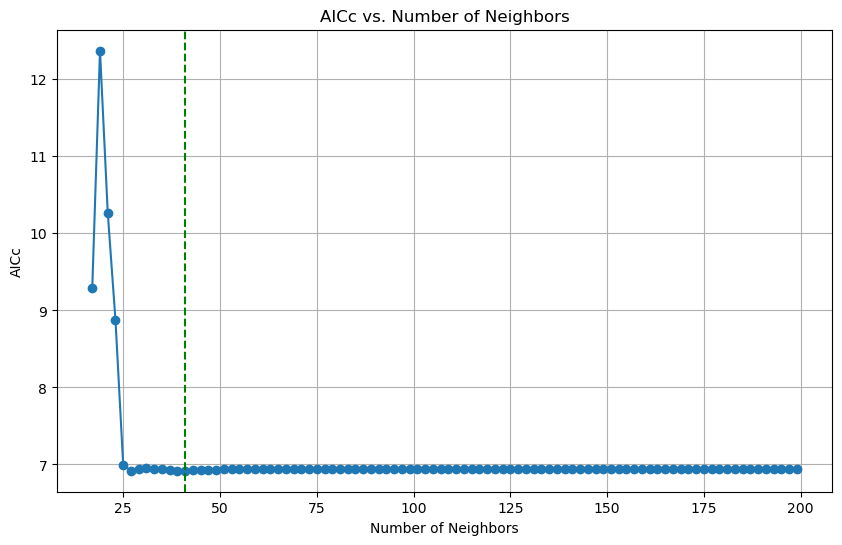

In [130]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

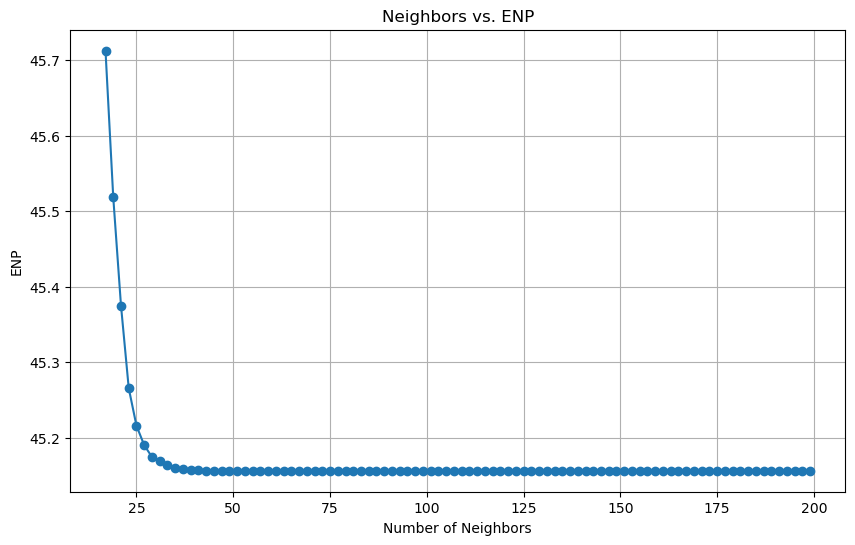

In [131]:
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, enp_values, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('ENP')
plt.title('Neighbors vs. ENP')
plt.grid(True)
plt.show()

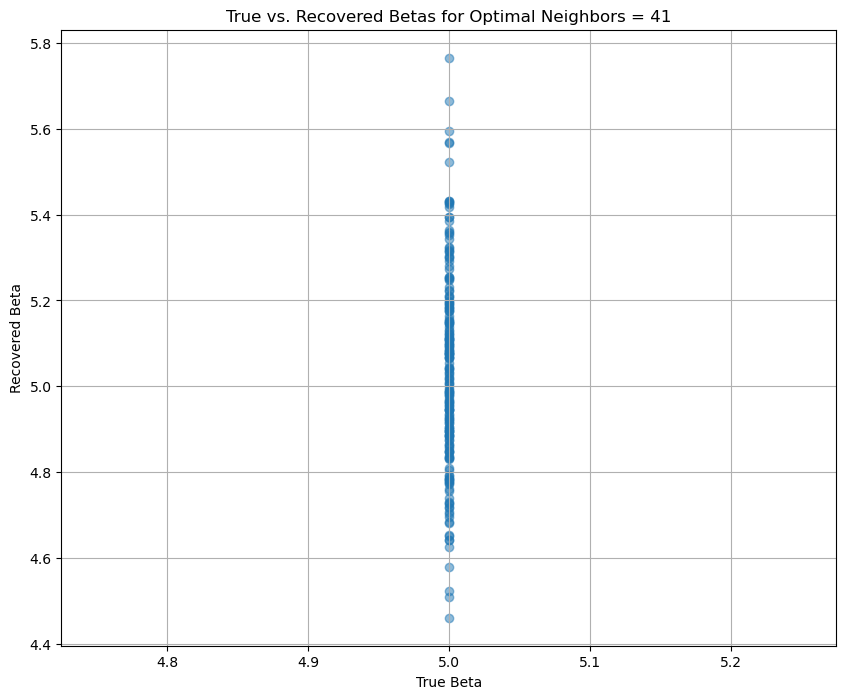

In [132]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors}')
plt.grid(True)
plt.show()

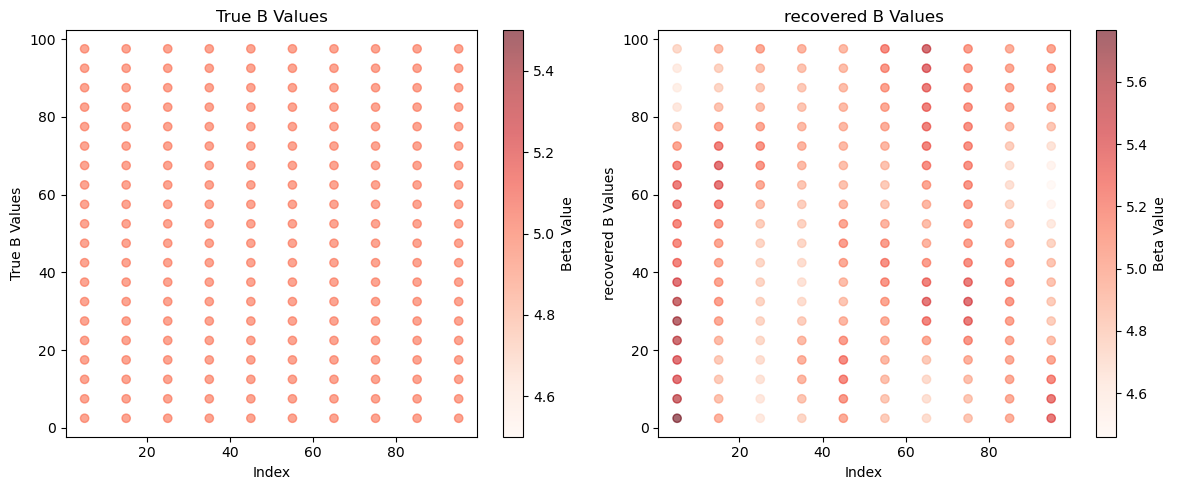

In [133]:
plot_true_and_recovered(B, recovered_betas, loc1)

In [134]:
B

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5])

In [135]:
recovered_betas

array([5.766, 5.567, 5.426, 5.432, 5.569, 5.664, 5.594, 5.433, 5.3  ,
       5.25 , 5.272, 5.321, 5.343, 5.281, 5.099, 4.85 , 4.653, 4.579,
       4.626, 4.761, 5.02 , 4.915, 4.848, 4.861, 4.959, 5.076, 5.129,
       5.111, 5.081, 5.097, 5.176, 5.292, 5.394, 5.417, 5.316, 5.111,
       4.9  , 4.786, 4.81 , 4.954, 4.642, 4.651, 4.68 , 4.72 , 4.755,
       4.78 , 4.79 , 4.783, 4.773, 4.783, 4.836, 4.936, 5.069, 5.182,
       5.197, 5.091, 4.946, 4.874, 4.926, 5.078, 4.778, 4.894, 4.99 ,
       5.018, 4.955, 4.832, 4.727, 4.694, 4.726, 4.774, 4.804, 4.83 ,
       4.886, 4.963, 5.002, 4.966, 4.896, 4.865, 4.905, 4.996, 5.065,
       5.176, 5.255, 5.252, 5.144, 4.986, 4.895, 4.945, 5.076, 5.148,
       5.097, 4.985, 4.919, 4.933, 4.971, 4.98 , 4.96 , 4.944, 4.948,
       4.966, 4.847, 4.875, 4.924, 4.977, 5.014, 5.046, 5.108, 5.192,
       5.223, 5.149, 5.008, 4.887, 4.856, 4.913, 4.991, 5.043, 5.079,
       5.124, 5.185, 5.247, 4.73 , 4.706, 4.74 , 4.862, 5.074, 5.299,
       5.395, 5.313,

#### Aggregating points into census tracts for GWR

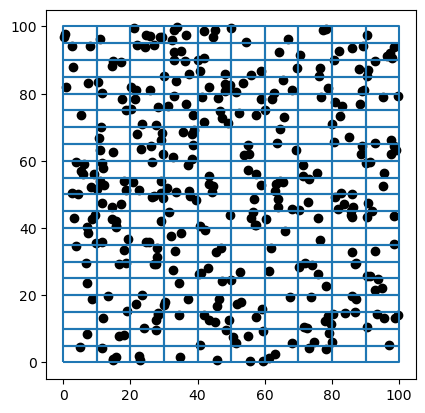

In [136]:
tracts_gdf.boundary.plot()
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

In [137]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))

In [138]:
df_S2.head()

,S2,geometry
0,74.801062,POINT (30.79350 51.93915)
1,58.675593,POINT (76.82977 78.92207)
2,108.023797,POINT (87.05621 18.79214)
3,45.694178,POINT (26.95052 49.61921)
4,83.671598,POINT (73.91217 19.49520)


<Axes: >

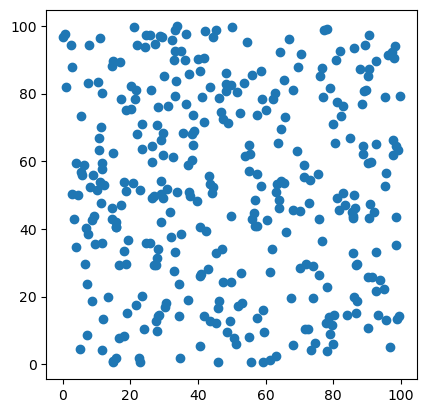

In [139]:
df_S2.plot()

#### Spatial Join and mean-aggregation

In [140]:
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')

In [141]:
joined.head()

,S2,geometry,index_right,tract_id
0,74.801062,POINT (30.79350 51.93915),70,70
33,61.987762,POINT (33.68172 50.83079),70,70
142,37.486025,POINT (37.44037 50.99988),70,70
1,58.675593,POINT (76.82977 78.92207),155,155
2,108.023797,POINT (87.05621 18.79214),163,163


<Axes: >

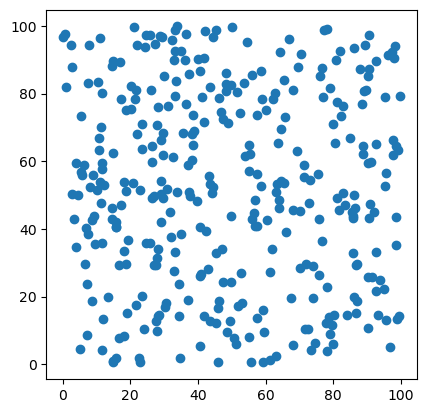

In [142]:
joined.plot()

In [143]:
sX = joined.groupby('tract_id').agg({'S2': ['mean']})#.reset_index()

In [144]:
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

In [145]:
# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')

In [146]:
sX1.head()

,tract_id,geometry,S2_mean
0,0,"POLYGON ((0.00000 0.00000, 10.00000 0.00000, 1...",14.719543
1,1,"POLYGON ((0.00000 5.00000, 10.00000 5.00000, 1...",70.528038
2,2,"POLYGON ((0.00000 10.00000, 10.00000 10.00000,...",NaN
3,3,"POLYGON ((0.00000 15.00000, 10.00000 15.00000,...",91.134917
4,4,"POLYGON ((0.00000 20.00000, 10.00000 20.00000,...",15.828319


In [147]:
sX1.isna().sum()

tract_id     0
geometry     0
S2_mean     31
dtype: int64

In [148]:
sX1.fillna({'S2_mean': 0.001}, inplace=True)

In [149]:
sX1.isna().sum()

tract_id    0
geometry    0
S2_mean     0
dtype: int64

In [150]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])

In [151]:
gwr_X.shape, gwr_y.shape

((200, 1), (200, 1))

#### Calibrate GWR

In [152]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [153]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [154]:
min(dict_aicc, key=dict_aicc.get)

198

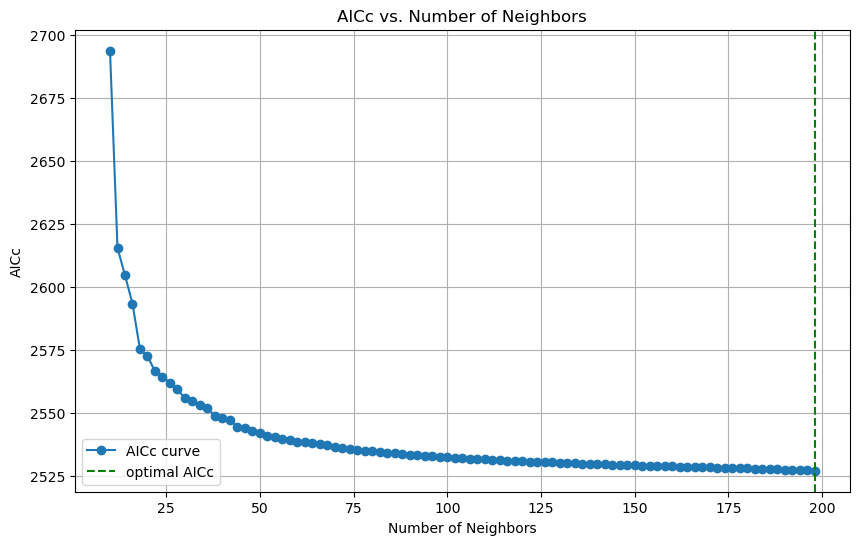

In [155]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

In [156]:
params[0].shape

(200, 1)

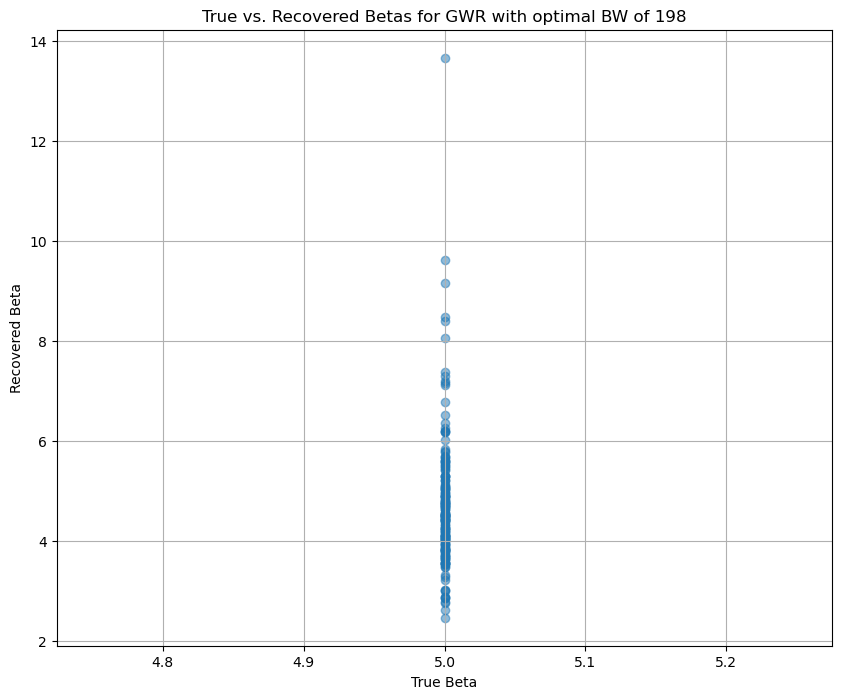

In [157]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)}")
plt.grid(True)
plt.show()

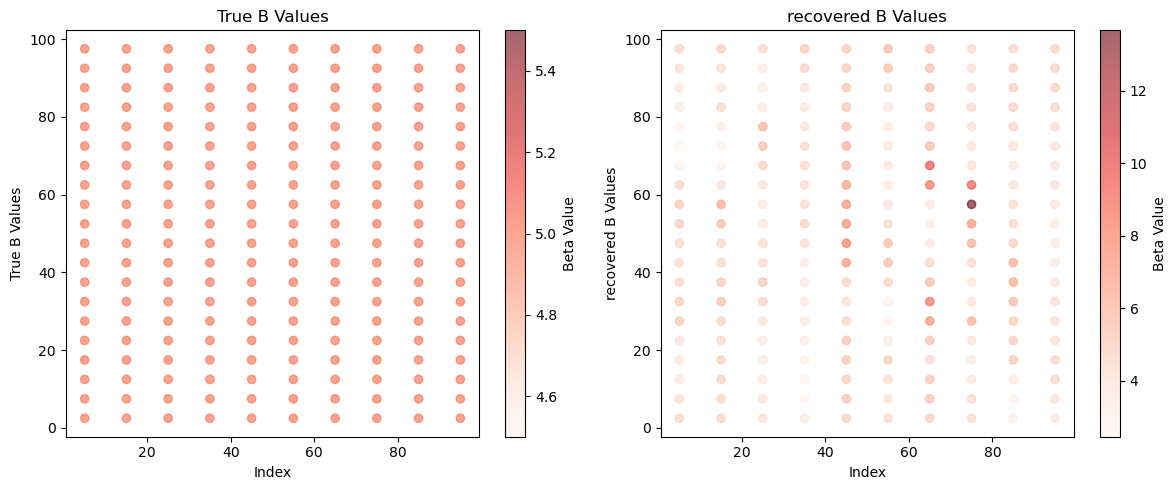

In [158]:
plot_true_and_recovered(B, params[0], loc1)

In [159]:
B

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5])

In [160]:
params[0].flatten()

array([ 4.621,  4.288,  3.789,  3.707,  4.124,  5.14 ,  5.083,  4.507,
        4.325,  4.638,  5.009,  5.202,  4.703,  2.857,  2.463,  3.005,
        3.525,  3.827,  4.232,  4.562,  4.719,  4.738,  4.886,  4.885,
        4.432,  4.721,  5.592,  5.211,  4.493,  4.558,  5.602,  6.521,
        3.999,  2.852,  2.774,  3.475,  4.529,  3.958,  4.219,  4.964,
        4.182,  4.09 ,  3.794,  3.641,  3.549,  3.945,  4.745,  5.226,
        4.512,  4.251,  3.911,  3.82 ,  4.045,  4.897,  5.483,  6.025,
        3.838,  3.321,  3.685,  4.556,  3.6  ,  2.764,  2.623,  3.025,
        3.549,  3.562,  3.637,  3.541,  3.707,  4.37 ,  4.878,  4.465,
        4.407,  4.465,  4.515,  4.12 ,  3.94 ,  4.043,  4.771,  5.089,
        4.978,  5.518,  5.053,  5.299,  5.423,  4.674,  4.253,  4.771,
        7.125,  8.053,  7.381,  7.286,  6.771,  6.18 ,  6.2  ,  5.688,
        5.303,  5.293,  5.089,  5.044,  4.474,  4.121,  4.341,  4.891,
        3.485,  2.874,  2.874,  4.81 ,  5.592,  5.586,  4.51 ,  3.87 ,
      